# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FBM myeloid lineage

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200713.h5ad')

In [4]:
adata.raw = adata

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell             327
CD8 T cell             171
CD14 monocyte         8787
CD56 bright NK         540
CMP                    425
                      ... 
schwann cells            9
sinusoidal EC          550
stromal macrophage    1493
tDC                    193
tip EC                 363
Length: 64, dtype: int64

In [6]:
myeloid_celltypes = ["CD14 monocyte", "DC precursor", "DC1", "DC2", "DC3", 
                     "GMP", "promonocyte", 
                     "myelocyte", "myeloid DC progenitor", "MOP", "neutrophil", "pDC", "pDC progenitor", 
                     "promyelocyte", "tDC"]

In [7]:
adata = adata[adata.obs['cell.labels'].isin(myeloid_celltypes)].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD14 monocyte            8787
DC1                        50
DC2                       598
DC3                       705
DC precursor              201
GMP                      1285
MOP                      3990
myelocyte                3854
myeloid DC progenitor      31
neutrophil               4516
pDC                       713
pDC progenitor             23
promonocyte              7676
promyelocyte             2386
tDC                       193
dtype: int64

In [9]:
adata.shape

(35008, 33712)

# Pre-process the dataset

In [10]:
# normalise count data 
sc.pp.normalize_total(adata)

In [11]:
# log the count data 
sc.pp.log1p(adata)

In [12]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [13]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [14]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [15]:
# run pca
sc.tl.pca(adata, n_comps=50)

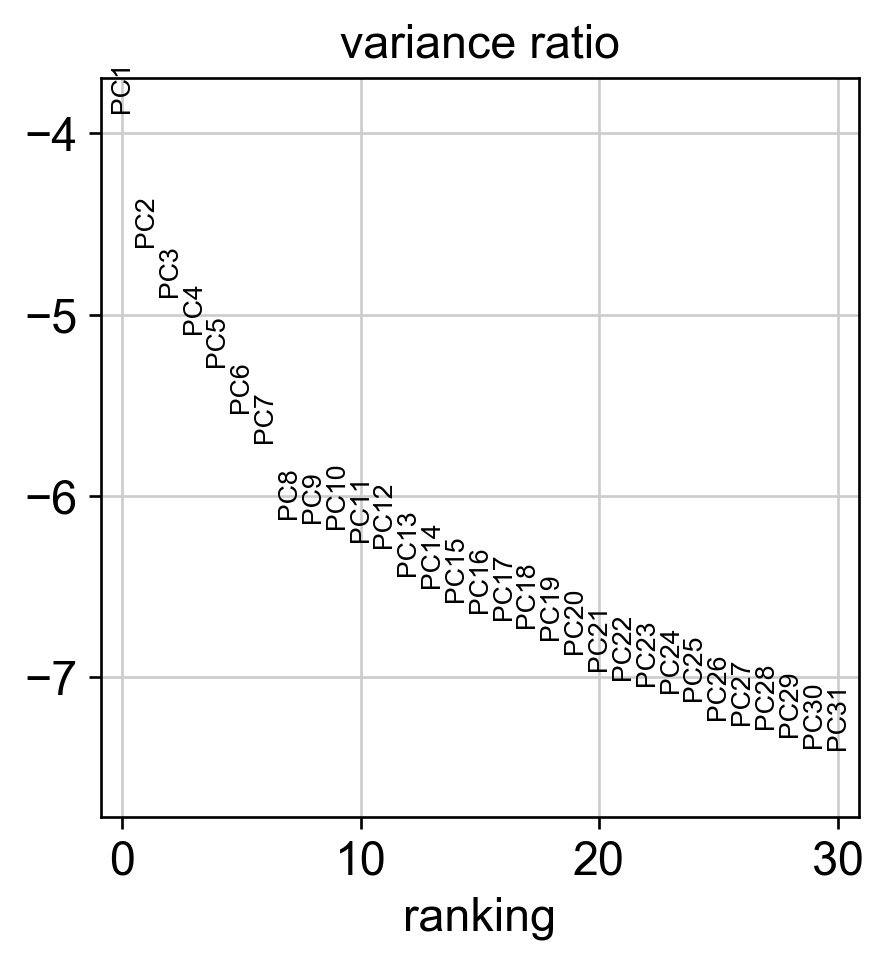

In [16]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [17]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [18]:
# run umap
sc.tl.umap(adata) 

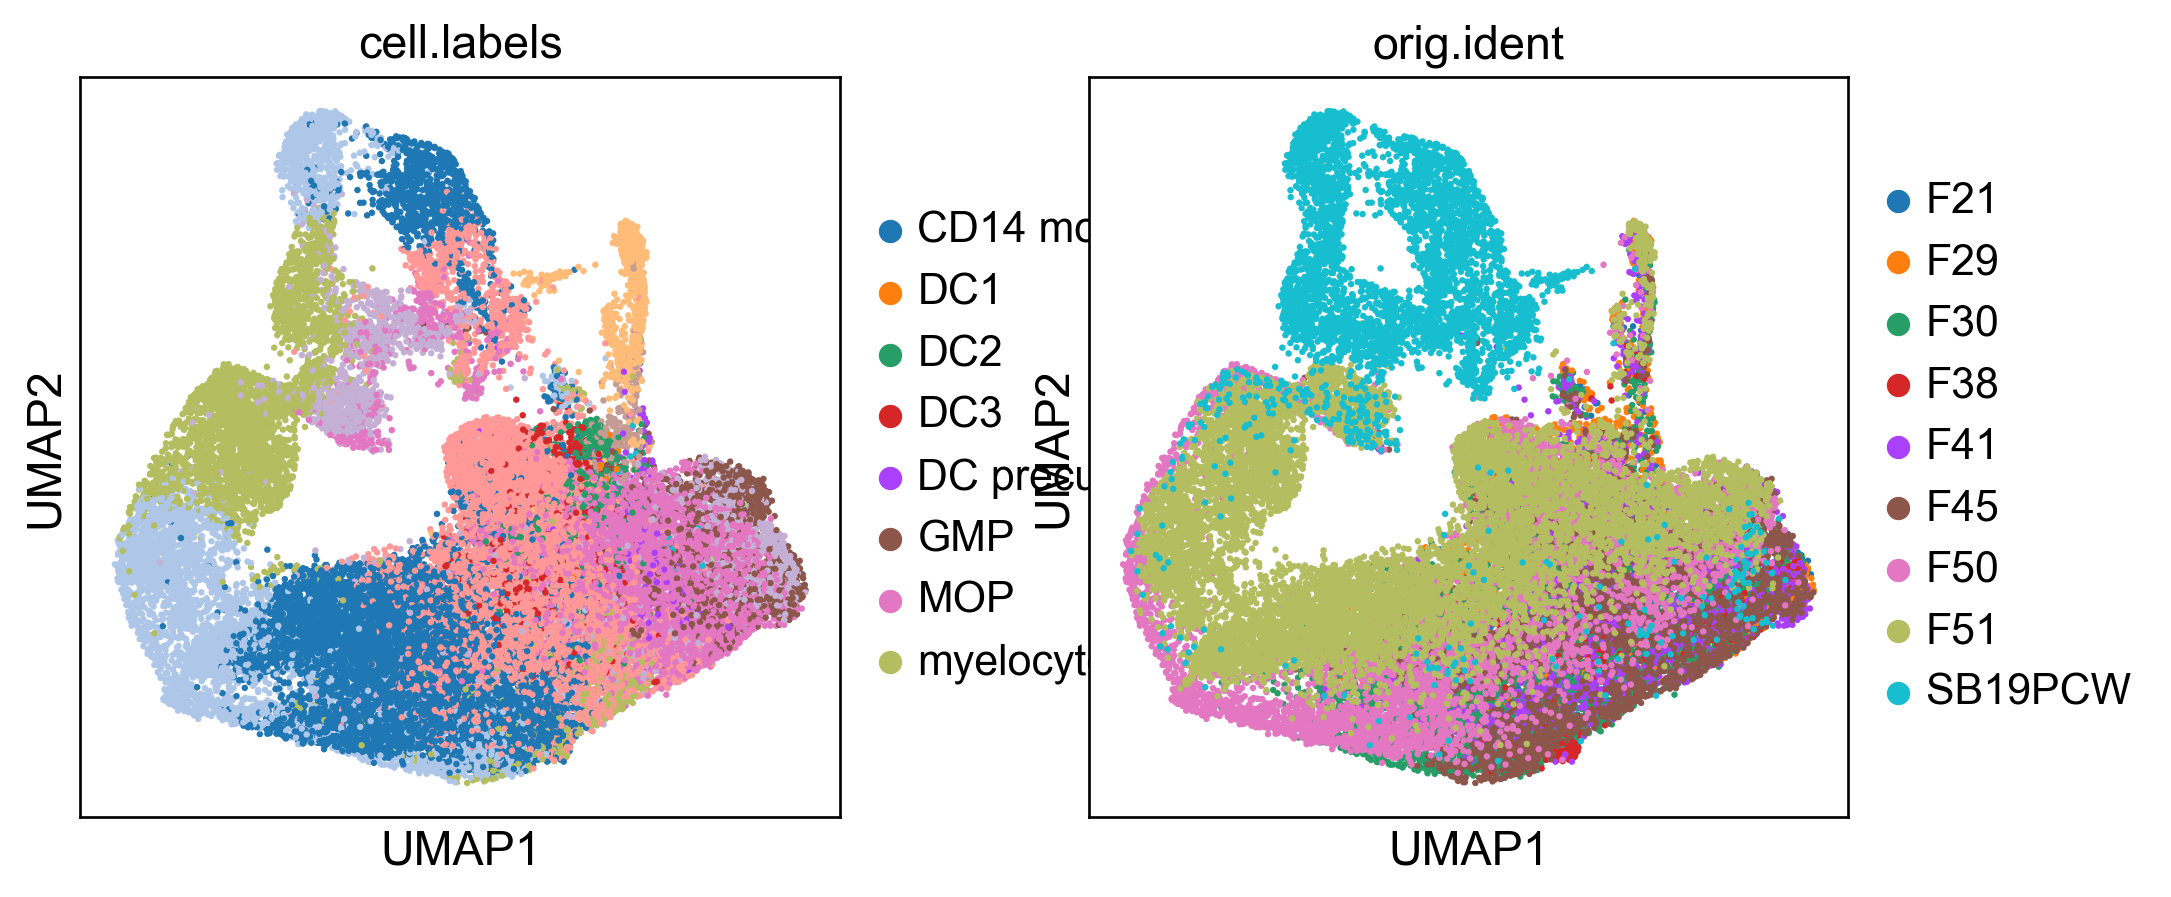

In [19]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Run harmony batch correction

In [20]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['orig.ident']

In [21]:
# load up harmony in rpy2
%load_ext rpy2.ipython

In [22]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

In [23]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add dimensional reduction post-harmony

In [24]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [25]:
# run umap
sc.tl.umap(adata)

In [26]:
# run fdg 
# As an input, FDG requires PCA coordinates and a snn graph. must redo snn graph if re-running fdg on subsets 
sc.tl.draw_graph(adata, init_pos='X_pca', layout='fa')

# Change the colours for the myeloid lineage

In [27]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['CD14 monocyte', 'DC1', 'DC2', 'DC3', 'DC precursor', 'GMP', 'MOP',
       'myelocyte', 'myeloid DC progenitor', 'neutrophil', 'pDC',
       'pDC progenitor', 'promonocyte', 'promyelocyte', 'tDC'],
      dtype='object')

In [28]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(["GMP", "MOP",   
                        "promyelocyte", "myelocyte", "neutrophil", 
                        "pDC progenitor", "pDC", "tDC", "myeloid DC progenitor",
                        "DC precursor", "DC1", "DC2", "DC3",
                        "promonocyte", "CD14 monocyte"])

In [29]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['GMP', 'MOP', 'promyelocyte', 'myelocyte', 'neutrophil',
       'pDC progenitor', 'pDC', 'tDC', 'myeloid DC progenitor', 'DC precursor',
       'DC1', 'DC2', 'DC3', 'promonocyte', 'CD14 monocyte'],
      dtype='object')

In [30]:
adata.obs["cell.labels"].cat.categories[2]

'promyelocyte'

In [31]:
new_colors = np.array(adata.uns["cell.labels_colors"])

new_colors[[0]] = '#00B5E0' # GMP
new_colors[[1]] = '#D1DB94' # MOP
new_colors[[2]] = '#87288A' # Promyelocyte
new_colors[[3]] = '#AD83BB' # Myelocyte
new_colors[[4]] = '#AAAAD5' # Neutrophil
new_colors[[5]] = '#1B437A' # pDC progenitor
new_colors[[6]] = '#DCADC0' # pDC
new_colors[[7]] = '#D43D6A' # tDC
new_colors[[8]] = '#196F8B' # Myeloid DC progenitor
new_colors[[9]] = '#E6DEC1' # DC precursor
new_colors[[10]] = '#A16728' # DC1
new_colors[[11]] = '#F59771' # DC2
new_colors[[12]] = '#F9F06C' # DC3
new_colors[[13]] = '#81C678' # Promonocyte
new_colors[[14]] = '#0B773C' # CD14 monocyte

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#00B5E0', '#D1DB94', '#87288A', '#AD83BB', '#AAAAD5', '#1B437A',
       '#DCADC0', '#D43D6A', '#196F8B', '#E6DEC1', '#A16728', '#F59771',
       '#F9F06C', '#81C678', '#0B773C'], dtype='<U7')

# Plot and save figs

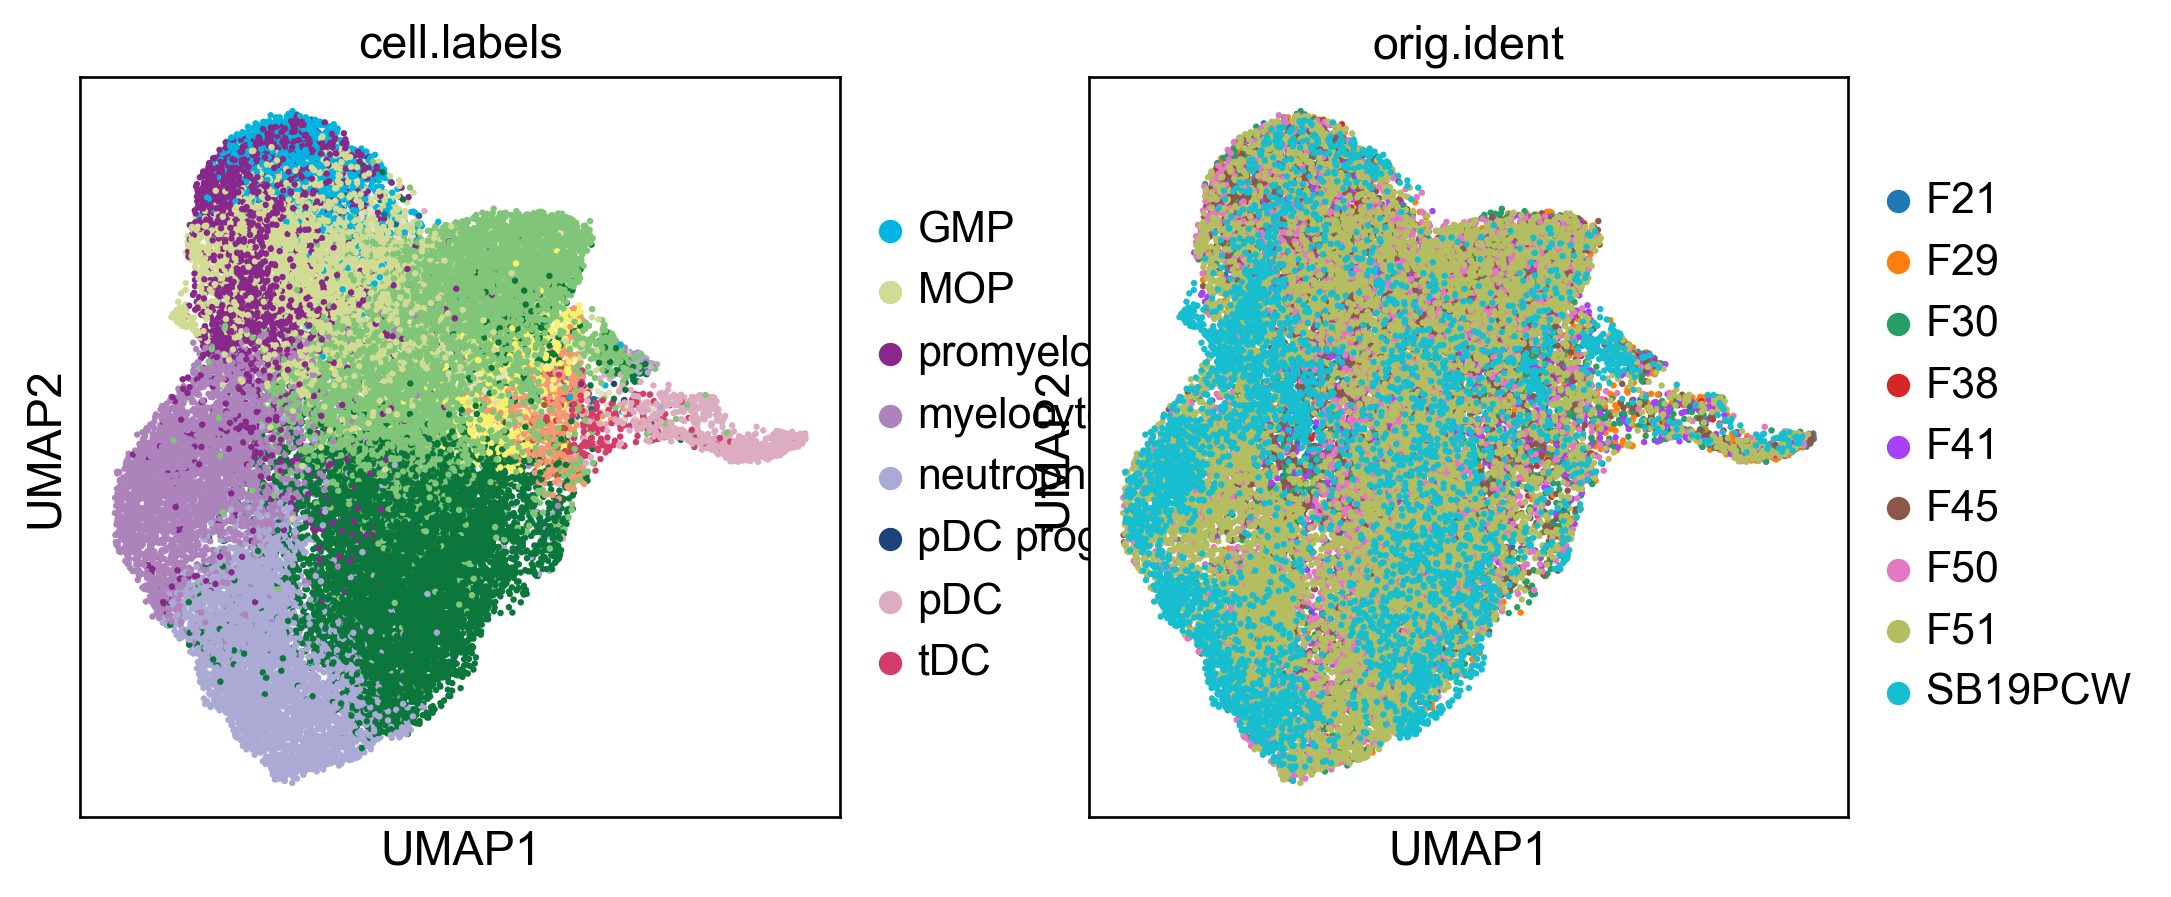

In [32]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

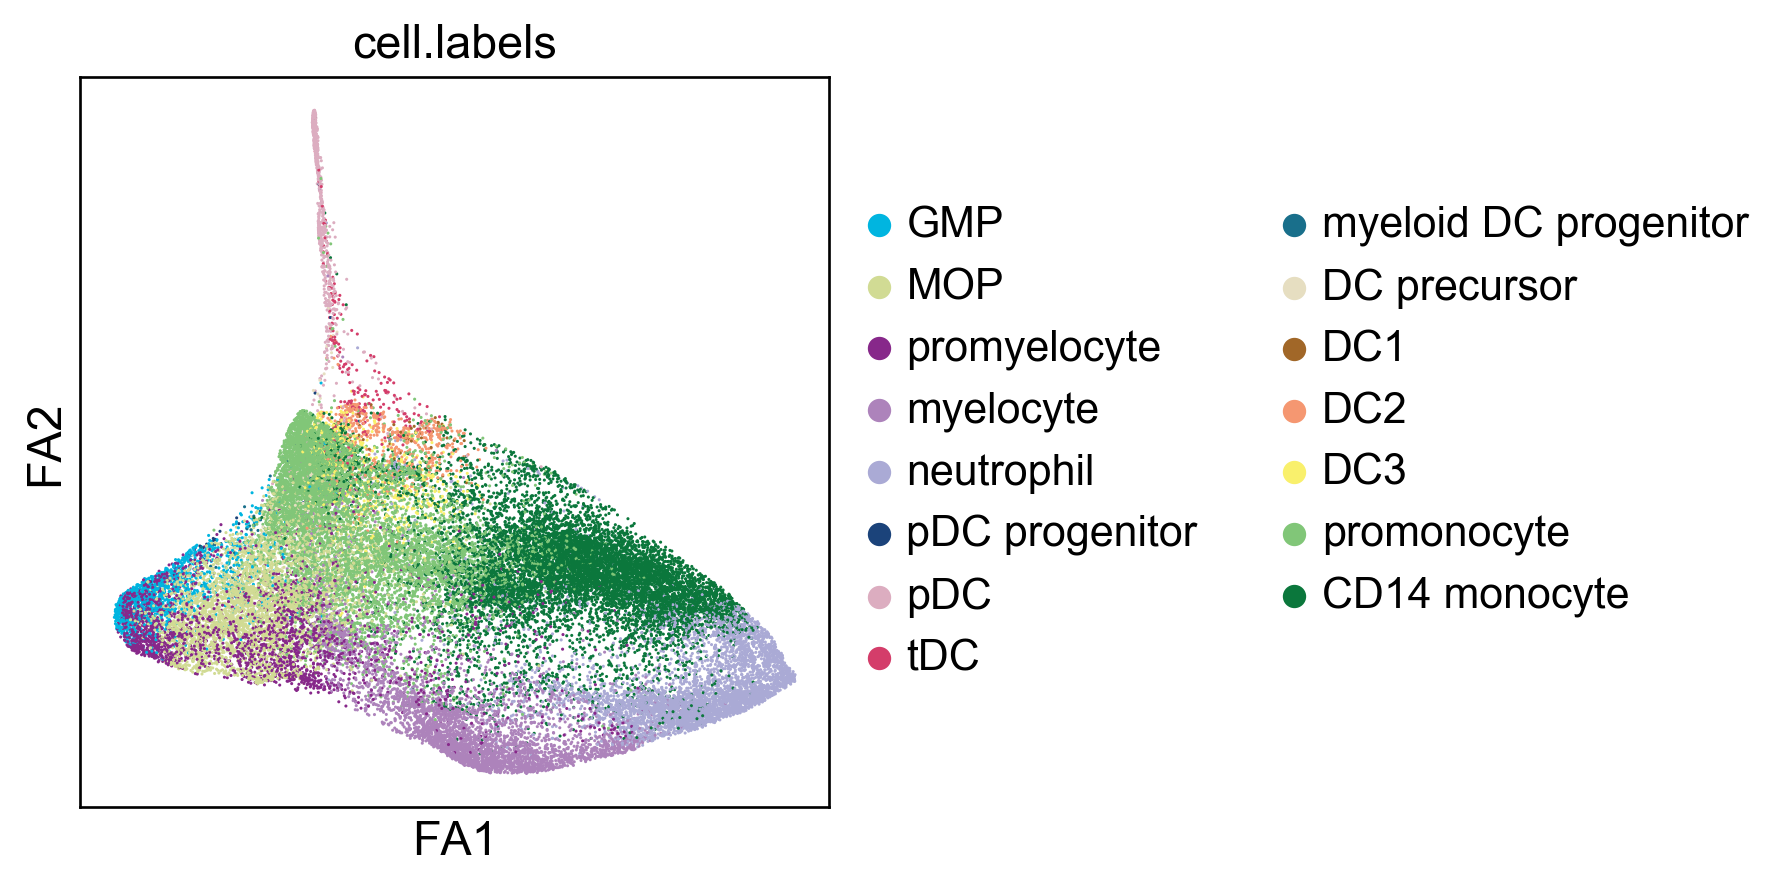

In [33]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa') 

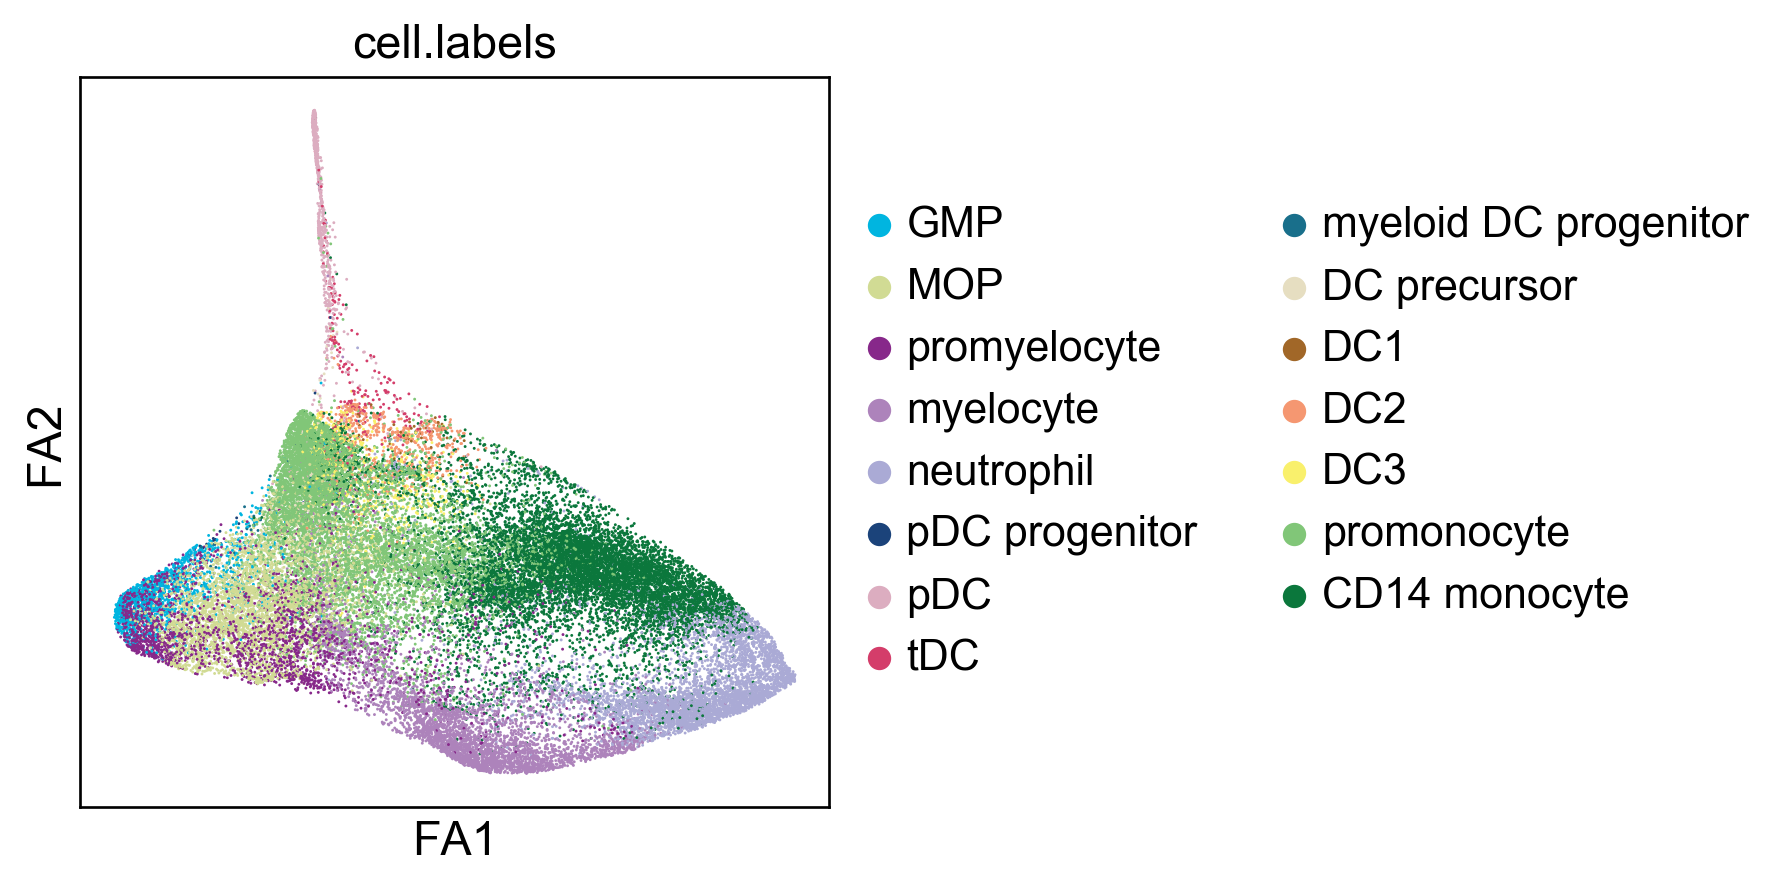

In [34]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa', size=3, show=True, 
                 save='_fig2a_myeloid_cell_labels_legoff_20200714.pdf')

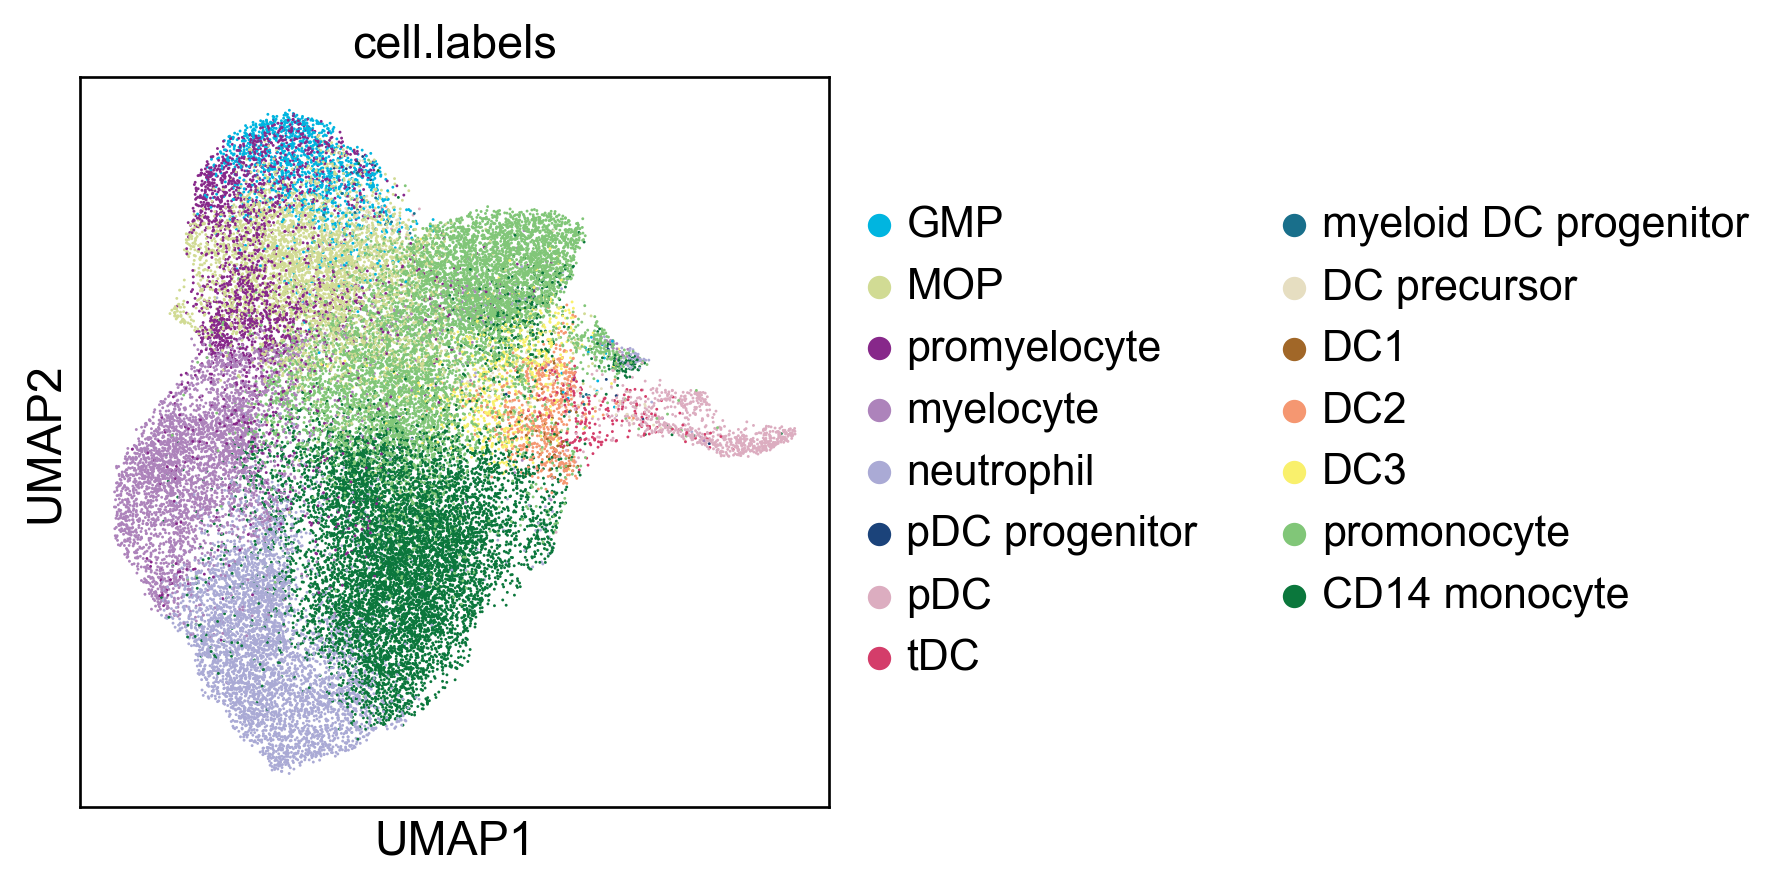

In [35]:
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.umap(adata, color=['cell.labels'], size=3, save="fig2a_myeloid_umap_20200714.pdf") 

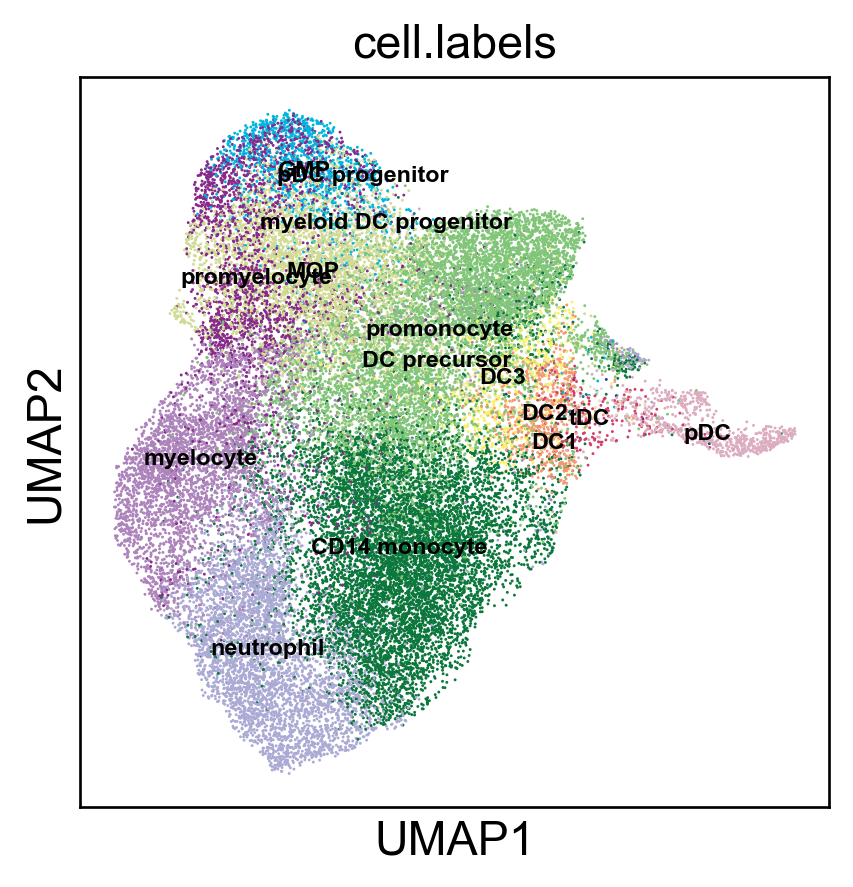

In [36]:
sc.pl.umap(adata, color=['cell.labels'], size=3, legend_loc="on data", legend_fontsize=7) 

# Save the data

In [37]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [38]:
adata.X

<35008x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 65187670 stored elements in Compressed Sparse Row format>

In [39]:
adata.raw.X

<35008x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 70715732 stored elements in Compressed Sparse Row format>

In [40]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig2a_myeloid_dr_20200714.h5ad")